In [1]:
BANNER = """
MMWXkolccc:::::::::::::::::::::cclokXWMM
MXd,.                              .,dXM
Xc.                            ..... .cX
k.                            .',;,.. .k
d.    ....................... .',;,.. .d
d.    'dOOOOOOOOOOOOOOOOOOOkdc'.....  .d
d.    ,0MMMMMMMMMMMMMMMMMMMMMWO;.     .d
d.    ,0MMMXdcccccccccccclOWMMWd.     .d
d.    ,0MMMO'             cXMMWx.     .d
d.    ,0MMMXocccccccccccclkWMMWd.     .d
d.    ,0MMMMMWWWWWWWWMMWMMMMMWK:.     .d
d.    ,0MMMWK000000000XWMMMNOo,.      .d
d.    ,0MMM0;.........,xNMMXo.        .d
d.    ,0MMM0,          .lKMMWO;.      .d
d.    'kXXXk'           .;kXXXO:.     .d
x.    ..'''..             .''''..     .x
0,                                    ,0
Wk,.                                .,kW
MWKd:'............................':dKWM
MMMMNKOxxddddddddddddddddddddddxxOKNMMMM
"""

In [2]:
#%pip install -U -r requirements.txt

In [3]:
import json
import math
import os
import time
from functools import partial
from urllib.parse import urlencode

import faiss
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import requests
from catboost import CatBoostRanker, Pool
from faiss import read_index, write_index
from sentence_transformers import SentenceTransformer
import shap
import datetime as dt
from matplotlib import pyplot as plt

# Загрузка данных

In [4]:
start_time = time.time()

In [ ]:
def download_file(pk, local_name):
    base_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?"

    final_url = base_url + urlencode(dict(public_key=pk))
    response = requests.get(final_url)
    download_url = response.json()["href"]

    download_response = requests.get(download_url)
    with open(local_name, "wb") as f:
        f.write(download_response.content)
        print(f"File {local_name} downloaded")


def download_from_yandex_disk():
    print(BANNER)

    files = {
        "features.parquet": "https://disk.yandex.ru/d/W_qJitz4dZGzAg",
        "videos.parquet": "https://disk.yandex.ru/d/JXz-oDfKFgm2Dw",
        "automarkup.parquet": "https://disk.yandex.ru/d/vP0FzQHdtxsz4Q",
        "manualmarkup.csv": "https://disk.yandex.ru/d/hDztN1rgW0JNjw",
    }

    filenames, filenames_to_delete = files.keys(), []
    for filename in filenames:
        if os.path.exists(filename):
            filenames_to_delete += [filename]
    for filename in filenames_to_delete:
        del files[filename]

    print(f"Will be download {len(files)} files")
    for filename, link in files.items():
        print(f"{filename} downloading in progress")
        download_file(link, filename)
        print(f"{filename} downloaded")

In [ ]:
download_from_yandex_disk()

In [5]:
seed = 42
np.random.seed(seed)

# Формирование базы векторов

In [6]:
candidates = pd.read_parquet(
    "videos.parquet", engine="pyarrow", columns=["video_id", "video_title"]
)

In [7]:
candidates

,video_id,video_title
0,video_6484084,Palia. Рыбалка за час. От 3 до 12 000 голды!
1,video_1522415,Прощание пройдет на чужбине...Нам будет не хва...
2,video_642363,#ДОБРОЛАП. ТВОРИМ ДОБРО ВМЕСТЕ!
3,video_10124356,8
4,video_16299346,Как обновить или переподключить аккаунт ВК в с...
...,...,...
34404556,video_29233614,Tarana - 'Myvatn' (Official Video)
34404557,video_26322511,"02.02.22 в 10.30 на Губернии ТБТ-Самара, ТБТ-Т..."
34404558,video_26756769,
34404559,video_13325265,ВОДОЛЕЙ ГОРОСКОП НА 26.12.2022-01.01.2023г


In [8]:
candidates = candidates.sample(n=7_000_000, replace=False, random_state=seed)

In [9]:
corpus = candidates["video_title"].apply(lambda x: x.lower()).values
video_ids = candidates["video_id"].values
del candidates

In [10]:
st_model = SentenceTransformer("cointegrated/rubert-tiny2", device="cuda")

In [11]:
# когда прогоните один раз у вас на диске уже будет сохранен faiss индекс
# можно поставить значение True, чтобы сэкономить время на формирование индекса
use_formed_index = True

In [12]:
d = 312
if not use_formed_index:
    cpu_index = faiss.IndexFlatL2(d)
    cpu_index.is_trained, cpu_index.ntotal

In [13]:
# если уже есть файл ind2videoid для вашего faiss индекса - True
use_formed_id_mapping = True

if not use_formed_id_mapping:
    ind2videoid = {ind: video_id for ind, video_id in enumerate(video_ids)}
    with open("ind2videoid.json", "w+") as f:
        json.dump(ind2videoid, f, indent=4)
else:
    with open("ind2videoid.json", "r") as f:
        ind2videoid = json.load(f)

In [14]:
batch_size = 100000
num_batches = math.ceil(len(corpus) / batch_size)

In [15]:
if not use_formed_index:
    try:
        embeddings_list = []

        for i in range(num_batches):
            # формируем батч
            start, end = i * batch_size, (i + 1) * batch_size
            corpus_batch = corpus[start:end]

            # считаем вектора для всех предложений в батче
            embeddings = st_model.encode(
                corpus_batch, batch_size=1000, show_progress_bar=True
            )

            # сохраняем вектора в список
            embeddings_list.append(embeddings)

            print(f"batch: {i + 1} / {num_batches}")

        # конкатенируем все вектора и добавляем их в индекс
        all_embeddings = np.concatenate(embeddings_list)
        cpu_index.add(all_embeddings)

        # сохраняем индекс в файл
        write_index(cpu_index, "candidates.index")

        print(f"Total vectors: {cpu_index.ntotal}")

    except KeyboardInterrupt:
        print("Остановлено пользователем")
    finally:
        # чистим ОЗУ
        del embeddings_list

In [16]:
# чистим ОЗУ
if not use_formed_index:
    del cpu_index

# Подбор кандидатов по базе векторов

In [17]:
automarkup = pd.read_parquet("automarkup.parquet", engine="pyarrow")

In [18]:
automarkup = automarkup[~automarkup["query"].isna()]
automarkup["query"] = automarkup["query"].apply(lambda x: x.lower())

In [19]:
n = 1000
top_n = automarkup["query"].value_counts()[: int(2 * n)].index.to_list()
other = np.array(automarkup["query"].value_counts()[int(2 * n) :].index.to_list())
#random_n = np.random.choice(other, size=n, replace=False).tolist()
queries = top_n
query2ind = {q: i for i, q in enumerate(queries)}

In [20]:
# когда прогоните один раз у вас на диске кандиды уже будут сохранены
# можете поставить значение True, чтобы сэкономить время
use_formed_candidates = True

In [21]:
qembeddings = st_model.encode(queries, batch_size=1000, show_progress_bar=True)

search_cpu_index = read_index("candidates.index")
search_cpu_index.is_trained, search_cpu_index.ntotal

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(True, 7000000)

In [22]:
generated_cand_name = "generated_candidates.parquet"
if not use_formed_candidates:
    topk = 100
    distance, faiss_ind = search_cpu_index.search(qembeddings, topk)

    generated_cand = {"query": [], "video_id": []}

    for i, q in enumerate(queries):
        vids = faiss_ind[i]
        generated_cand["video_id"] += [ind2videoid[v] for v in vids]
        generated_cand["query"] += [q] * len(vids)

    generated_cand = pd.DataFrame(generated_cand)

    generated_cand.to_parquet(generated_cand_name, engine="pyarrow")
else:
    generated_cand = pd.read_parquet(generated_cand_name, engine="pyarrow")

# Формирование таргета по авторазметке

In [23]:
automarkup["target"] = [1] * automarkup.shape[0]
candidates_with_target = generated_cand.merge(
    automarkup[["query", "video_id", "target"]],
    how="left",
    left_on=["query", "video_id"],
    right_on=["query", "video_id"],
)
candidates_with_target["target"] = candidates_with_target["target"].fillna(0)

In [24]:
automarkup.head()

,is_authorized,datetime,query,video_id,duration,position,watchtime,emotion,vtop,comment,channel,tv_show,season,target
0,False,2023-07-03 14:29:34+03:00,приют комедиантов роман бабаян,video_3049590,2279019,8.0,0,0,None,0,ТЕЛЕКАНАЛ ЗВЕЗДА,Десять мгновений,Сезон,1
1,False,2023-07-20 04:39:07+03:00,бабаян роман,video_3049590,2279019,1.0,0,0,None,0,ТЕЛЕКАНАЛ ЗВЕЗДА,Десять мгновений,Сезон,1
2,True,2023-08-10 17:39:06+03:00,роман бабаян,video_3049590,2279019,1.0,102,0,None,0,ТЕЛЕКАНАЛ ЗВЕЗДА,Десять мгновений,Сезон,1
3,False,2023-07-03 17:09:31+03:00,битва экстрасенсов 2019 год,video_31592942,4259447,45.0,3601,0,None,0,Экстрасенсы. Битва сильнейших,Экстрасенсы. Битва сильнейших,None,1
4,False,2023-07-03 15:13:37+03:00,битва сильнейших 2 сезон,video_31592942,4259447,4.0,4054,0,None,0,Экстрасенсы. Битва сильнейших,Экстрасенсы. Битва сильнейших,None,1


# Анализ запросов

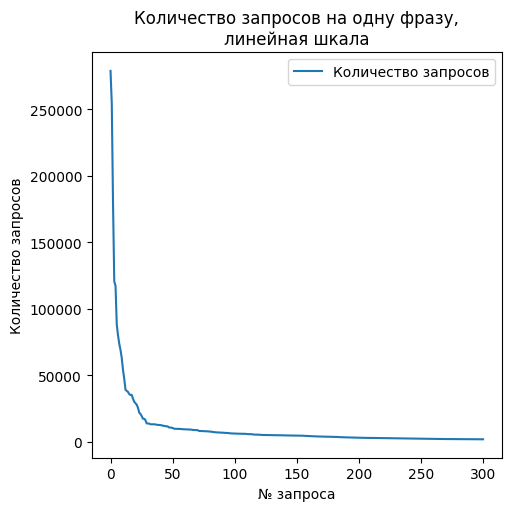

In [25]:
x = np.linspace(0, 300, 300) 
y = automarkup['query'].value_counts()[:300]

fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
ax.plot(x, y, label='Количество запросов')
ax.set_xlabel('№ запроса')
ax.set_ylabel('Количество запросов')
ax.set_title("Количество запросов на одну фразу,\nлинейная шкала")
ax.legend()

divide by zero encountered in log


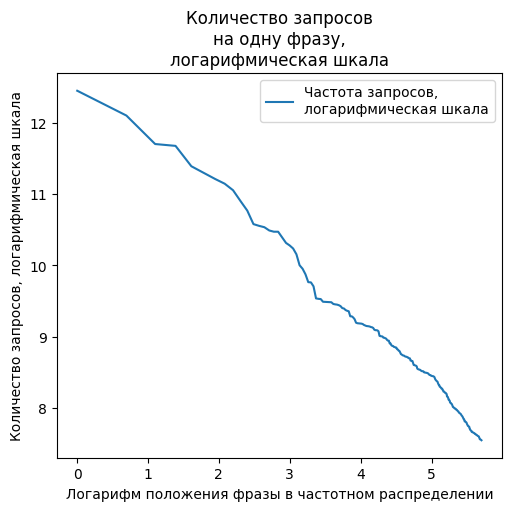

In [26]:
x = np.log(np.linspace(0, 300, 300) )
y = np.log(automarkup['query'].value_counts()[:300])

fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
ax.plot(x, y, label='Частота запросов,\nлогарифмическая шкала')
ax.set_xlabel('Логарифм положения фразы в частотном распределении')
ax.set_ylabel('Количество запросов, логарифмическая шкала')
ax.set_title("Количество запросов\nна одну фразу,\nлогарифмическая шкала")
ax.legend()

In [27]:
# очищаем ОЗУ
del generated_cand
del search_cpu_index
del automarkup
del st_model
del qembeddings

In [28]:
# здесь мы используем признаки актуальные на состояние 2-ого мая 2023 года
# вы можете использовать признаки наиболее актуальные для вашего кандидата

#features_parquet = pq.ParquetFile("features.parquet")
#features, filter_date = None, "2023-05-02"

#for batch in features_parquet.iter_batches():
#    tmp = batch.to_pandas()
#    if features is None:
#        features = tmp[tmp["report_date"] == filter_date]
#    else:
#        features = pd.concat([features, tmp[tmp["report_date"] == filter_date]], axis=0)

# для baseline выбросим категориальные признаки и datetime признаки
# в своем решении вы сами можете решить использовать их или нет
#features = features.drop(
#    ["v_channel_reg_datetime", "v_channel_type", "v_category", "v_pub_datetime"], axis=1
#)

In [29]:
features = pd.read_parquet("features.parquet", engine="pyarrow")
quant = True
if quant:
    quantile_threshold = 0.999
    views_quantile_threshold = features['v_year_views'].quantile(quantile_threshold)
    likes_quantile_threshold = features['v_likes'].quantile(quantile_threshold)
    features = features[
        (features['v_year_views'] >= views_quantile_threshold) &
        (features['v_likes'] >= likes_quantile_threshold)
    ]
    
features['v_channel_reg_datetime'] = pd.to_datetime(features['v_channel_reg_datetime'])
features['v_pub_datetime'] = pd.to_datetime(features['v_pub_datetime'])
features['report_date'] = pd.to_datetime(features['report_date'])

features['likes_dislikes_ratio'] = features['v_likes'] / (features['v_dislikes'] + 1)
features['views_per_like'] = features['v_year_views'] / (features['v_likes'] + 1)
features['comments_per_view'] = features['total_comments'] / features['v_year_views']
features['likes_per_view'] = features['v_likes'] / features['v_year_views']

features['channel_existence_duration'] = (features['v_pub_datetime'] - features['v_channel_reg_datetime']).dt.days
features['video_age'] = (features['report_date'] - features['v_pub_datetime']).dt.days

features['pub_year'] = features['v_pub_datetime'].dt.year
features['pub_month'] = features['v_pub_datetime'].dt.month
features['pub_day_of_week'] = features['v_pub_datetime'].dt.dayofweek
features['pub_hour'] = features['v_pub_datetime'].dt.hour
features['publish_season'] = features['v_pub_datetime'].dt.quarter
features['publish_time_of_day'] = pd.cut(features['pub_hour'], bins=[-1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

features = features.drop(
    ["v_channel_reg_datetime","v_pub_datetime", "report_date"], axis=1 # "v_channel_type", "v_category", 
)

In [30]:
# Просмотр первых нескольких строк датасета
display(features.head())

# Общая информация о датасете
display(features.info())

# Статистика по числовым признакам
display(features.describe())

# Проверка наличия пропущенных значений
display(features.isnull().sum())

,video_id,v_channel_type,v_category,total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,...,comments_per_view,likes_per_view,channel_existence_duration,video_age,pub_year,pub_month,pub_day_of_week,pub_hour,publish_season,publish_time_of_day
10406,video_5866731,ТВ И СМИ,Телепередачи,34,47268,15571,1418,161,9,0,...,0.000719,0.000190,744,35,2023,3,0,0,1,Night
25877,video_14044662,ТВ И СМИ,Спорт,38,19919,19919,72,9,49,0,...,0.001908,0.002460,3206,27,2023,4,1,16,2,Afternoon
27527,video_12561562,ТВ И СМИ,Юмор,14,19016,19016,19016,1445,53,0,...,0.000736,0.002787,1233,2,2023,4,5,8,2,Morning
33431,video_11081589,ТВ И СМИ,Телепередачи,613,994410,202665,38219,5620,30,0,...,0.000616,0.000030,724,50,2023,3,6,17,1,Afternoon
50721,video_10518164,ТВ И СМИ,Телепередачи,45,394602,63601,15848,2251,30,0,...,0.000114,0.000076,289,485,2022,1,5,10,1,Morning


<class 'pandas.core.frame.DataFrame'>
Index: 16836 entries, 10406 to 65451523
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   video_id                      16836 non-null  object  
 1   v_channel_type                16836 non-null  object  
 2   v_category                    16836 non-null  object  
 3   total_comments                16836 non-null  int64   
 4   v_year_views                  16836 non-null  int64   
 5   v_month_views                 16836 non-null  int64   
 6   v_week_views                  16836 non-null  int64   
 7   v_day_views                   16836 non-null  int64   
 8   v_likes                       16836 non-null  int64   
 9   v_dislikes                    16836 non-null  int64   
 10  v_duration                    16836 non-null  int64   
 11  v_cr_click_like_7_days        16836 non-null  float64 
 12  v_cr_click_dislike_7_days     16836 non-null

None

,total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,v_cr_click_like_7_days,v_cr_click_dislike_7_days,...,views_per_like,comments_per_view,likes_per_view,channel_existence_duration,video_age,pub_year,pub_month,pub_day_of_week,pub_hour,publish_season
count,16836.000000,1.683600e+04,1.683600e+04,1.683600e+04,16836.000000,16836.000000,16836.000000,1.683600e+04,16836.000000,16836.000000,...,16836.000000,16836.000000,16836.000000,16836.000000,16836.000000,16836.000000,16836.000000,16836.000000,16836.000000,16836.000000
mean,168.274828,1.930172e+05,3.010227e+04,6.735857e+03,903.535579,102.847232,2.068959,2.463761e+06,0.003606,0.000045,...,3773.437227,0.000659,0.001942,1184.455690,316.725232,2022.394690,5.818306,3.027619,13.940010,2.255940
std,3719.631486,7.536983e+05,1.690359e+05,4.624913e+04,6824.447940,329.295992,8.068606,2.175437e+06,0.027586,0.001080,...,12397.184417,0.002419,0.005793,1091.334856,402.120083,1.108712,3.067087,1.969837,5.105419,1.012372
min,0.000000,1.592100e+04,0.000000e+00,0.000000e+00,0.000000,9.000000,0.000000,0.000000e+00,0.000000,0.000000,...,8.349265,0.000000,0.000002,-2007.000000,-89.000000,2012.000000,1.000000,0.000000,0.000000,1.000000
25%,6.000000,2.331850e+04,1.504000e+03,2.180000e+02,23.000000,14.000000,0.000000,5.141340e+05,0.000000,0.000000,...,763.751116,0.000137,0.000307,431.000000,70.000000,2022.000000,3.000000,1.000000,10.000000,1.000000
50%,15.000000,3.779950e+04,4.401000e+03,8.050000e+02,102.000000,27.000000,0.000000,2.515334e+06,0.000566,0.000000,...,1576.414216,0.000352,0.000599,787.000000,174.000000,2023.000000,5.000000,3.000000,15.000000,2.000000
75%,43.000000,9.144575e+04,1.641700e+04,2.429000e+03,303.000000,68.000000,1.000000,3.088767e+06,0.002018,0.000000,...,3088.588415,0.000678,0.001274,1786.000000,477.000000,2023.000000,8.000000,5.000000,18.000000,3.000000
max,287265.000000,1.862395e+07,6.090112e+06,2.359747e+06,427290.000000,6946.000000,174.000000,3.705201e+07,1.000000,0.125000,...,525175.666667,0.089769,0.119727,3983.000000,4094.000000,2023.000000,12.000000,6.000000,23.000000,4.000000


video_id                        0
v_channel_type                  0
v_category                      0
total_comments                  0
v_year_views                    0
v_month_views                   0
v_week_views                    0
v_day_views                     0
v_likes                         0
v_dislikes                      0
v_duration                      0
v_cr_click_like_7_days          0
v_cr_click_dislike_7_days       0
v_cr_click_vtop_7_days          0
v_cr_click_long_view_7_days     0
v_cr_click_comment_7_days       0
v_cr_click_like_30_days         0
v_cr_click_dislike_30_days      0
v_cr_click_vtop_30_days         0
v_cr_click_long_view_30_days    0
v_cr_click_comment_30_days      0
v_cr_click_like_1_days          0
v_cr_click_dislike_1_days       0
v_cr_click_vtop_1_days          0
v_cr_click_long_view_1_days     0
v_cr_click_comment_1_days       0
likes_dislikes_ratio            0
views_per_like                  0
comments_per_view               0
likes_per_view

In [31]:
#features.to_parquet("cleared_features.parquet")
views_quantile_threshold, likes_quantile_threshold

(15920.41400000453, 9.0)

# Формирование дата сеuniqueс признаками

In [32]:
full_df = candidates_with_target.merge(
    features, how="inner", left_on="video_id", right_on="video_id"
)
del features
full_df = full_df.drop_duplicates()

In [33]:
groups_to_drop = []
full_df["group_id"] = full_df.groupby(["query"]).ngroup()
for group in full_df["group_id"].unique():
    part_df = full_df[full_df["group_id"] == group]
    target_sum = part_df["target"].values.sum()
    if target_sum <= 0:
        groups_to_drop += [group]
full_df = full_df[~full_df["group_id"].isin(groups_to_drop)]

In [34]:
full_df.target.unique()

array([0., 1.])

In [35]:
full_df.to_parquet("full_df.parquet")

In [36]:
#full_df = pd.read_parquet("full_df.parquet")
groups = pd.Series(full_df["group_id"].unique())
permutation = groups.sample(frac=1, random_state=seed)
train_groups, val_groups, test_groups = np.split(
    permutation, [int(0.75 * len(permutation)), int(0.90 * len(permutation))]
)

In [37]:
train_df = full_df[full_df["group_id"].isin(train_groups)]
val_df = full_df[full_df["group_id"].isin(val_groups)]
test_df = full_df[full_df["group_id"].isin(test_groups)]

In [38]:
train_df = train_df.sort_values("group_id")
val_df = val_df.sort_values("group_id")
test_df = test_df.sort_values("group_id")

In [39]:
metainfo_columns = ["query", "video_id", "target", "group_id"]

X_train = train_df.drop(metainfo_columns, axis=1)
y_train, g_train = train_df["target"], train_df["group_id"]

X_val = val_df.drop(metainfo_columns, axis=1)
y_val, g_val = val_df["target"], val_df["group_id"]

X_test = test_df.drop(metainfo_columns, axis=1)
y_test, g_test = test_df["target"], test_df["group_id"]

In [40]:
categorical_features = [
    "v_channel_type",
    "v_category",
    "pub_year",
    "pub_month",
    "pub_hour",
    "pub_day_of_week",
    "publish_season",
    "publish_time_of_day"
]
train = Pool(
    data=X_train.values,
    label=y_train.values,
    group_id=g_train.values,
    feature_names=X_train.columns.to_list(),
    cat_features=categorical_features
)

val = Pool(
    data=X_val.values,
    label=y_val.values,
    group_id=g_val.values,
    feature_names=X_val.columns.to_list(),
    cat_features=categorical_features
)

test = Pool(
    data=X_test.values,
    label=y_test.values,
    group_id=g_test.values,
    feature_names=X_test.columns.to_list(),
    cat_features=categorical_features
)

# Обучение модели

In [41]:
task_type = "GPU"
metric_period = 250

parameters = {
    "task_type": task_type,
    "verbose": False,
    "random_seed": seed,
    "loss_function": "QueryRMSE",
    "learning_rate": 0.001,
    "l2_leaf_reg": 30,
    "iterations": 4000,
    "max_depth": 3,
}

In [42]:
model = CatBoostRanker(**parameters)
model = model.fit(
    train, eval_set=val, plot=True, use_best_model=True, metric_period=metric_period
)
model.save_model("ranker.ckpt")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Измерение метрик

In [43]:
def _metrics_at(at, model, pool, metric="NDCG"):
    metric = metric + f":top={at}"
    eval_metrics = model.eval_metrics(pool, metrics=[metric])
    best_metrics = {}
    for key in eval_metrics.keys():
        best_metrics[key] = eval_metrics[key][model.best_iteration_]
    return best_metrics


metrics_train_at = partial(_metrics_at, model=model, pool=train)

metrics_val_at = partial(_metrics_at, model=model, pool=val)

metrics_test_at = partial(_metrics_at, model=model, pool=test)

In [44]:
metrics_train_at(1), metrics_train_at(5)

({'NDCG:top=1;type=Base': 0.8620689655172413},
 {'NDCG:top=5;type=Base': 0.8728876899713441})

In [45]:
metrics_val_at(1), metrics_val_at(5)

({'NDCG:top=1;type=Base': 0.9622641509433962},
 {'NDCG:top=5;type=Base': 0.9497483826034927})

In [46]:
metrics_test_at(1), metrics_test_at(5)

({'NDCG:top=1;type=Base': 0.8285714285714286},
 {'NDCG:top=5;type=Base': 0.8384340383499106})

2023-11-24 23:55:43.694345: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 23:55:44.280012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 23:55:44.280143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 23:55:44.379003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 23:55:44.579555: I tensorflow/core/platform/cpu_feature_guar

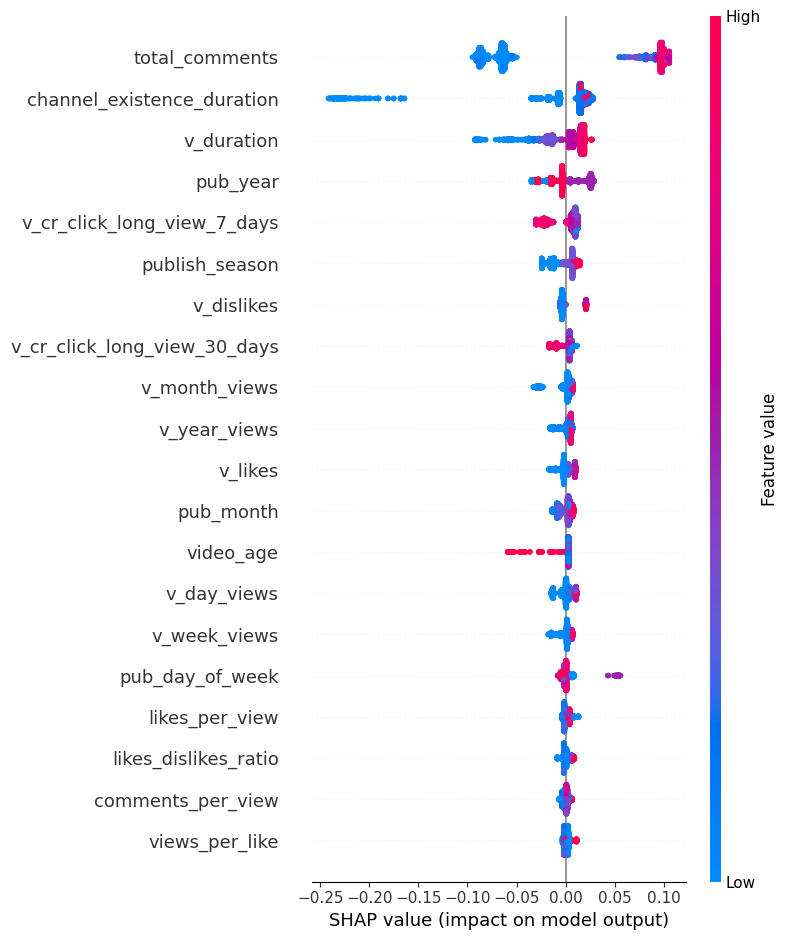

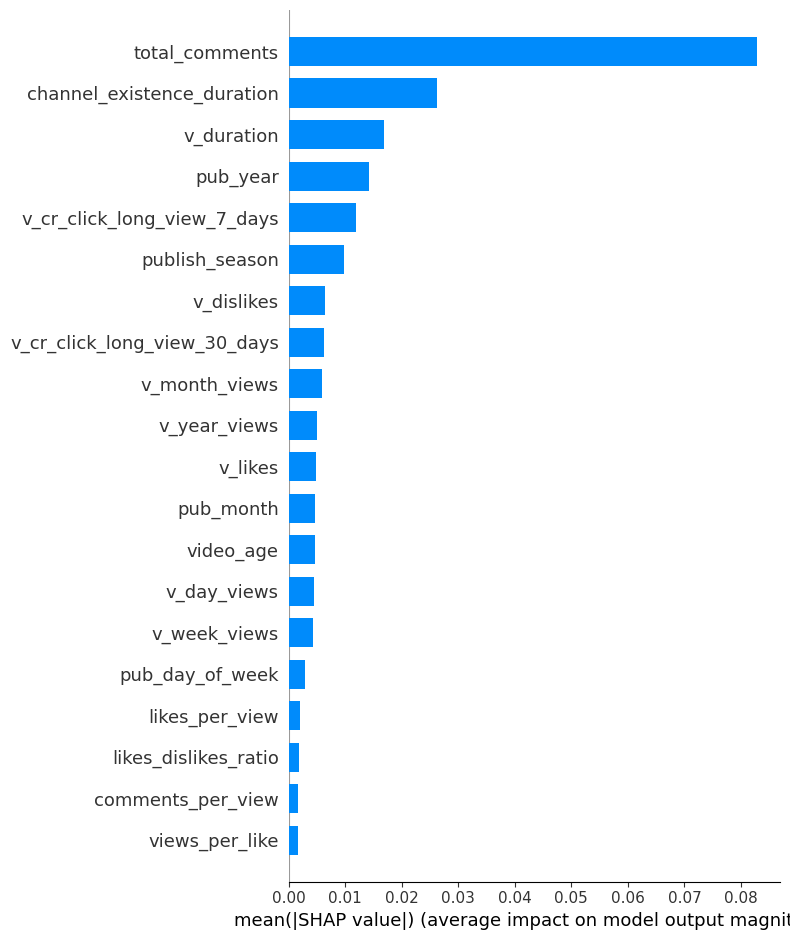

In [47]:
shap_explainer = shap.Explainer(model)
shap_values = shap_explainer.shap_values(X_train.values)
shap.summary_plot(shap_values, X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')

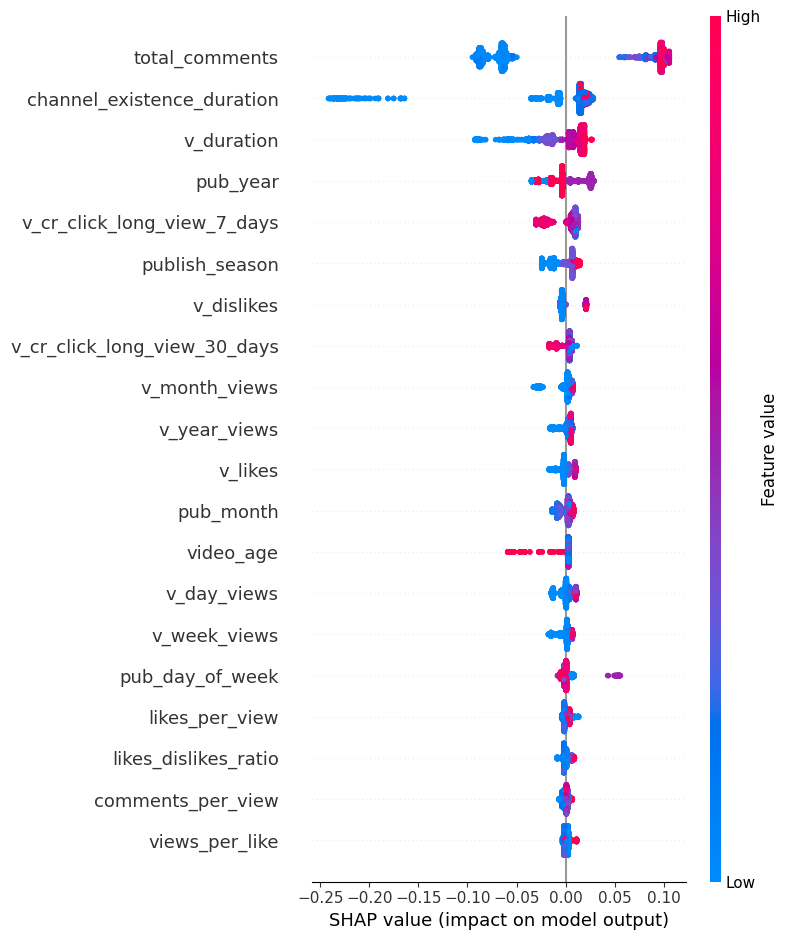


In [48]:
# очищаем ОЗУ
del model
del full_df
del train_df, val_df, test_df
del train, val, test
del X_train, y_train, g_train
del X_val, y_val, g_val
del X_test, y_test, g_test

In [49]:
end_time = time.time()
total_time = (end_time - start_time) / 60
print(f"Общее время работы baseline: {int(total_time)} минут")

Общее время работы baseline: 1 минут


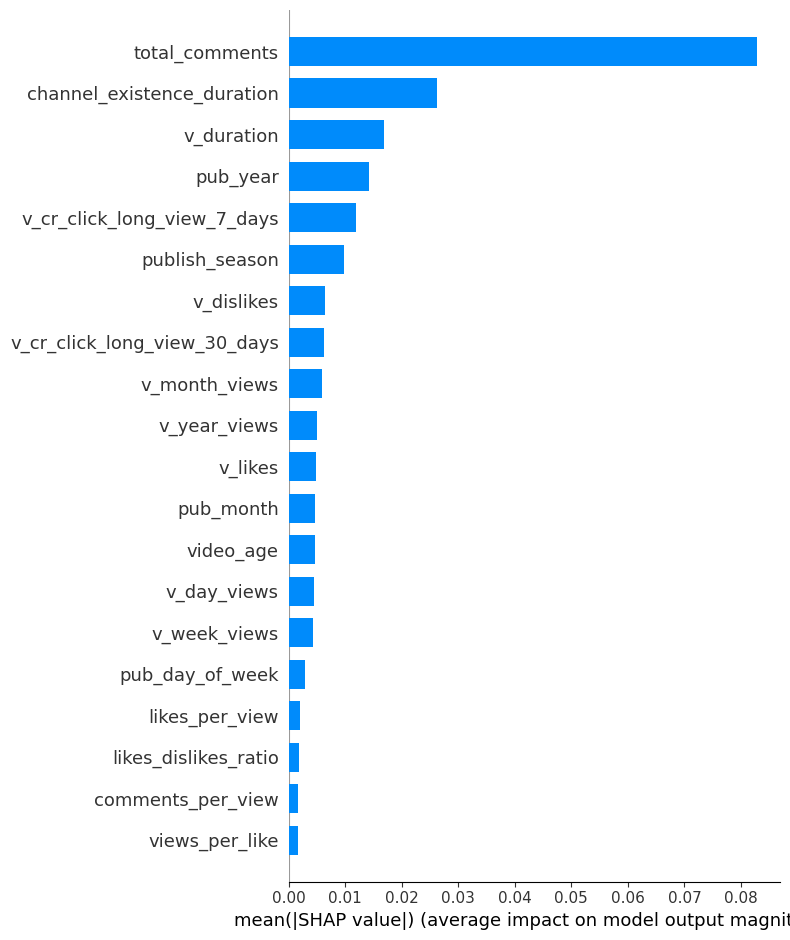